In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch

from dystformer.patchtst.pipeline import PatchTSTPipeline

/stor/work/AMDG_Gilpin_Summer2024/miniconda3/envs/dystformer_jeff/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
run_name = "pft_chattn_emb_w_poly-0"
pft_model = PatchTSTPipeline.from_pretrained(
    mode="predict",
    pretrain_path=f"/stor/work/AMDG_Gilpin_Summer2024/checkpoints/{run_name}/checkpoint-final",
    device_map="cuda:0",
)

In [3]:
def get_attn_weights(model, key: str) -> list[dict[str, torch.Tensor]]:
    params = [
        {
            "Wq": getattr(l, key).q_proj.weight,
            "Wk": getattr(l, key).k_proj.weight,
            "Wv": getattr(l, key).v_proj.weight,
        }
        for l in model.model.model.encoder.layers  # lol
    ]
    return params


def get_attn_map(
    weights: list[dict[str, torch.Tensor]], index: int, shift: bool = False
) -> np.ndarray:
    attn_map = (weights[index]["Wq"] @ weights[index]["Wk"].T).detach().cpu().numpy()
    if shift:
        attn_map = (attn_map - np.min(attn_map)) / (np.max(attn_map) - np.min(attn_map))
    return attn_map


def symmetric_distance(attn_map: np.ndarray) -> float:
    return (
        0.5
        * np.linalg.norm(attn_map - attn_map.T, "fro")
        / np.linalg.norm(attn_map, "fro")
    )  # type: ignore

In [4]:
temporal_weights = get_attn_weights(pft_model, "temporal_self_attn")
channel_weights = get_attn_weights(pft_model, "channel_self_attn")

0.606904951865347


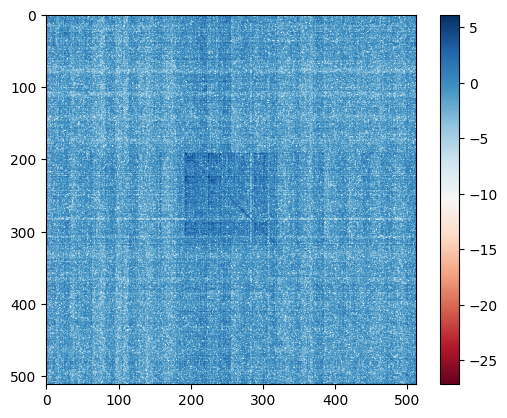

In [5]:
attn_map = get_attn_map(temporal_weights, 0)
print(symmetric_distance(attn_map))
plt.figure()
plt.imshow(np.log(attn_map**2), cmap="RdBu")
plt.colorbar()
plt.show()

0.6166007079691087


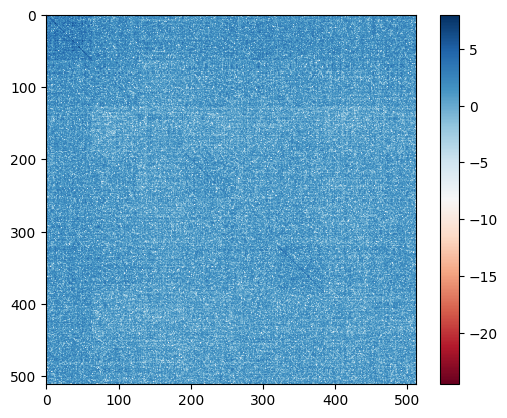

In [6]:
attn_map = get_attn_map(channel_weights, 0)
print(symmetric_distance(attn_map))
plt.figure()
plt.imshow(np.log(attn_map**2), cmap="RdBu")
plt.colorbar()
plt.show()

Sequential(
  (0): Linear(in_features=512, out_features=512, bias=True)
  (1): GELUActivation()
  (2): Identity()
  (3): Linear(in_features=512, out_features=512, bias=True)
)
0.7067333390909651


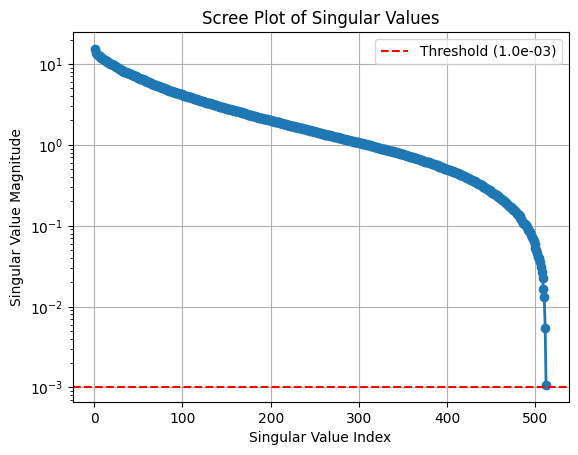

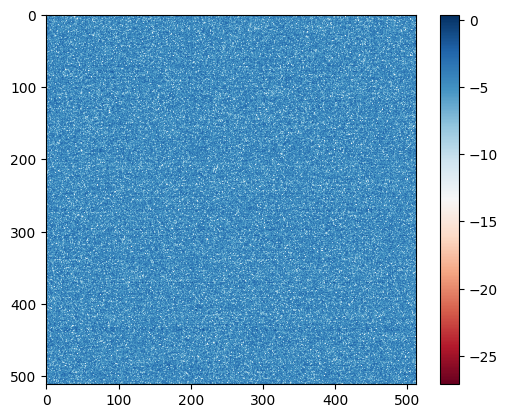

In [7]:
llayer = pft_model.model.model.encoder.layers[0].ff
print(llayer)
ffw = llayer[0].weight.detach().cpu().numpy()
print(symmetric_distance(ffw))

U, S, V = np.linalg.svd(ffw)
threshold = 1e-3
rank = np.sum(S > threshold)
plt.figure()
plt.plot(range(1, len(S) + 1), S, "o-", linewidth=2)
plt.title("Scree Plot of Singular Values")
plt.xlabel("Singular Value Index")
plt.ylabel("Singular Value Magnitude")
plt.grid(True)
plt.yscale("log")  # Log scale to better visualize the decay
plt.axhline(
    y=threshold, color="r", linestyle="--", label=f"Threshold ({threshold:.1e})"
)
plt.legend()
plt.show()

reconstructed = U[:, :rank] @ np.diag(S)[:rank, :rank] @ V[:rank, :]
plt.figure()
plt.imshow(np.log(reconstructed**2), cmap="RdBu")
plt.colorbar()
plt.show()

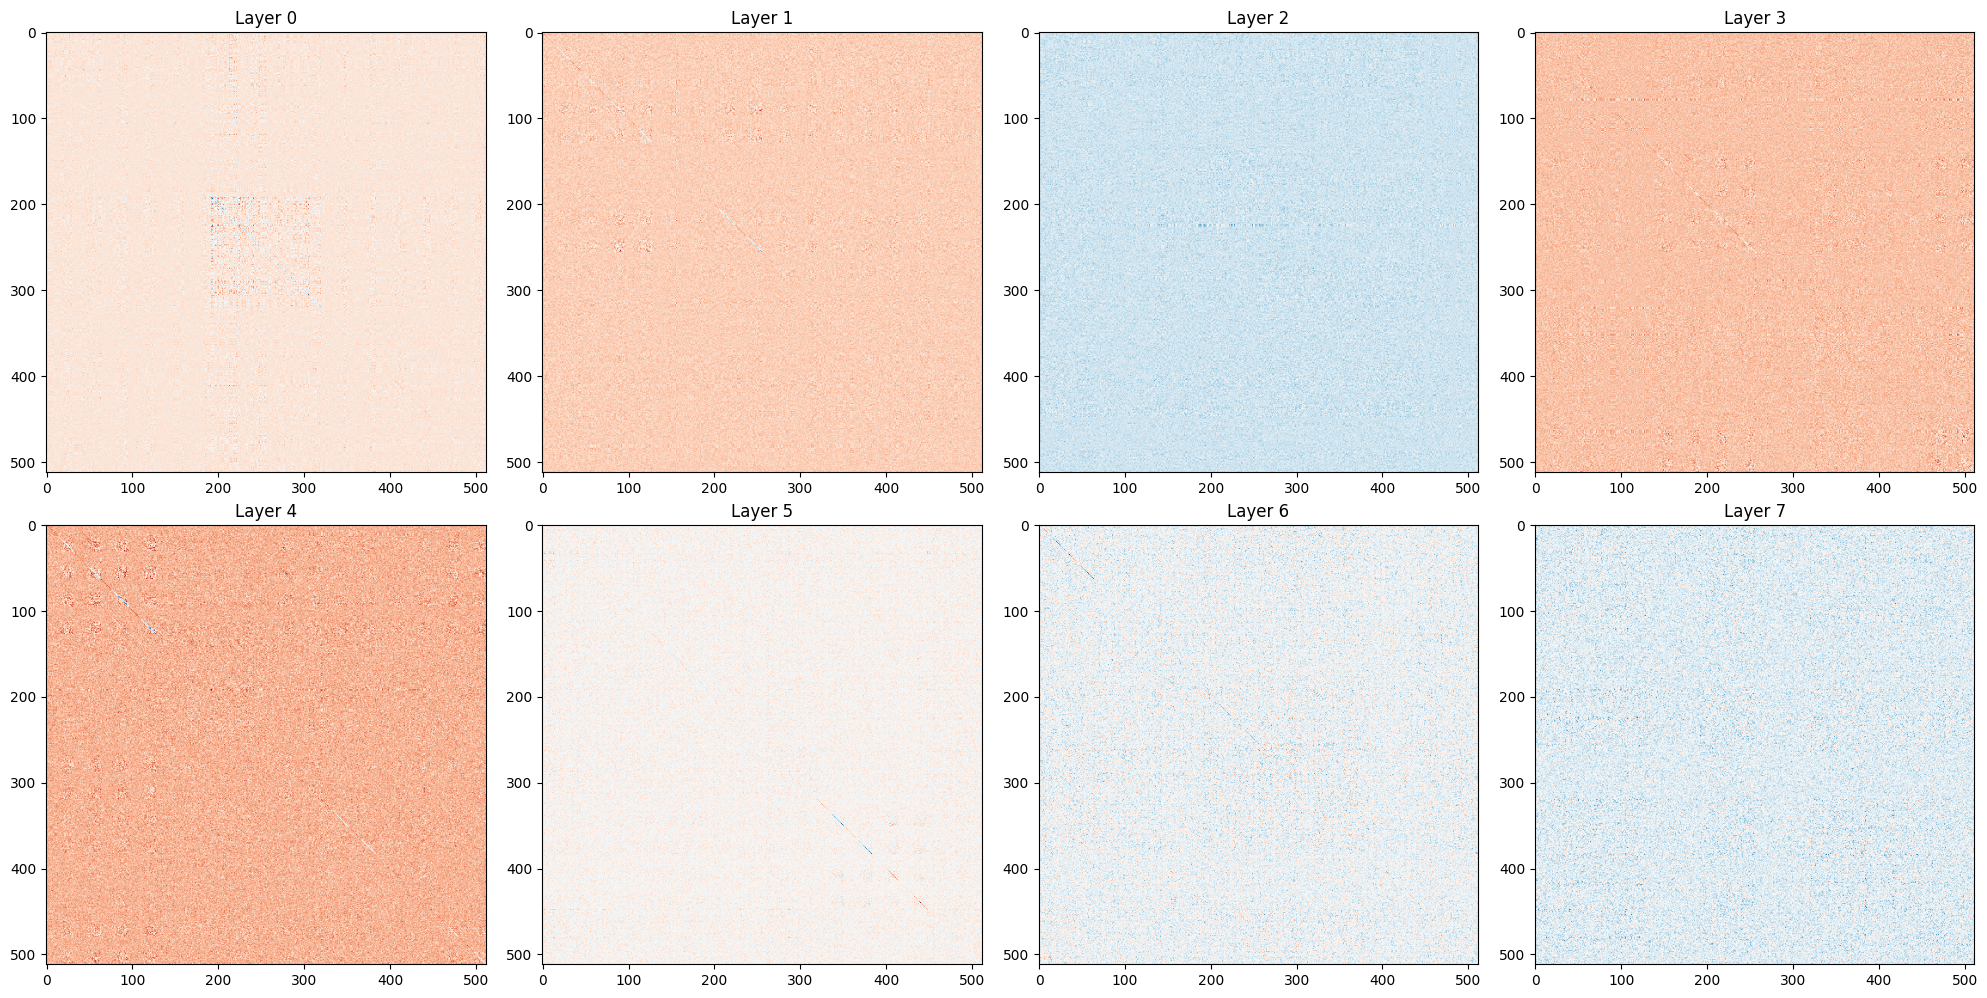

In [8]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
for i, ax in enumerate(axes.flatten()):
    attn_map = get_attn_map(temporal_weights, i)
    ax.imshow(attn_map, cmap="RdBu")
    ax.set_title(f"Layer {i}")
plt.tight_layout()
plt.show()

In [9]:
def plot_attn_map(
    model,
    context: np.ndarray,
    patch_size: int,
    sample_idx: int,
    layer_idx: int,
    head_idx: int,
    prefix: str = "",
) -> None:
    """Plot attention matrix with corresponding timeseries patches along edges."""
    attention_type = "temporal" if layer_idx % 2 == 0 else "channel"
    patches = context.reshape(context.shape[0], -1, patch_size)
    if attention_type == "channel":
        patches = patches.transpose(1, 0, 2)

    context_tensor = torch.from_numpy(context.T).float().to(pft_model.device)[None, ...]
    pred = model(context_tensor, output_attentions=True)
    attn_weights = pred.attentions

    # Extract attention weights for specified sample, layer and head
    num_samples = attn_weights[layer_idx].shape[0]
    attn = attn_weights[layer_idx][sample_idx, head_idx].detach().cpu().numpy()
    n_patches = attn.shape[0]

    # Create figure with gridspec layout
    fig = plt.figure(figsize=(10, 10))

    # Create main grid with padding for colorbar
    outer_grid = fig.add_gridspec(1, 2, width_ratios=[1, 0.05], wspace=0.05)

    # Create sub-grid for the plots
    gs = outer_grid[0].subgridspec(
        2, 2, width_ratios=[0.15, 0.85], height_ratios=[0.15, 0.85], wspace=0, hspace=0
    )

    # Plot attention matrix first to get its size
    ax_main = fig.add_subplot(gs[1, 1])
    im = ax_main.imshow(attn, extent=(0, n_patches, n_patches, 0))
    ax_main.set_xticks([])
    ax_main.set_yticks([])

    # Plot patches along top
    ax_top = fig.add_subplot(gs[0, 1])
    for i in range(n_patches):
        x = np.linspace(i, i + 1, patch_size)
        ax_top.plot(x, patches[sample_idx, i], linewidth=1)
    ax_top.set_xlim(0, n_patches)
    ax_top.set_xticks([])
    ax_top.set_yticks([])
    ax_top.grid(True)

    # Plot patches along left side
    ax_left = fig.add_subplot(gs[1, 0])
    for i in range(n_patches):
        y = np.linspace(i, i + 1, patch_size)
        ax_left.plot(-patches[sample_idx, i], y, linewidth=1)
    ax_left.set_ylim(n_patches, 0)
    ax_left.set_xticks([])
    ax_left.set_yticks([])
    ax_left.grid(True)

    # Add colorbar
    ax_cbar = fig.add_subplot(outer_grid[1])
    plt.colorbar(im, cax=ax_cbar)

    # Remove empty subplot
    fig.delaxes(fig.add_subplot(gs[0, 0]))

    # Force exact alignment of subplots
    main_pos = ax_main.get_position()
    ax_top.set_position(
        [main_pos.x0, main_pos.y1, main_pos.width, ax_top.get_position().height]  # type: ignore
    )
    ax_left.set_position(
        [
            ax_left.get_position().x0,
            main_pos.y0,
            ax_left.get_position().width,
            main_pos.height,
        ]  # type: ignore
    )
    ax_cbar.set_position(
        [
            ax_cbar.get_position().x0,
            main_pos.y0,
            ax_cbar.get_position().width,
            main_pos.height,
        ]  # type: ignore
    )
    sample_type = "channel" if attention_type == "temporal" else "patch"
    ax_top.set_title(
        f"{prefix}{attention_type} attention @ layer {layer_idx}, head {head_idx}, ({sample_type} {sample_idx + 1}/{num_samples})"
    )
    plt.tight_layout()
    plt.show()

In [10]:
from dystformer.utils import get_system_filepaths, load_trajectory_from_arrow

dyst_name = "Lorenz"
test_data_dirs = "/stor/work/AMDG_Gilpin_Summer2024/data/final_base40"
syspaths = get_system_filepaths(dyst_name, test_data_dirs, "train")

sample_idx = 0
trajectory, _ = load_trajectory_from_arrow(syspaths[sample_idx])

/tmp/ipykernel_2646284/672954935.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


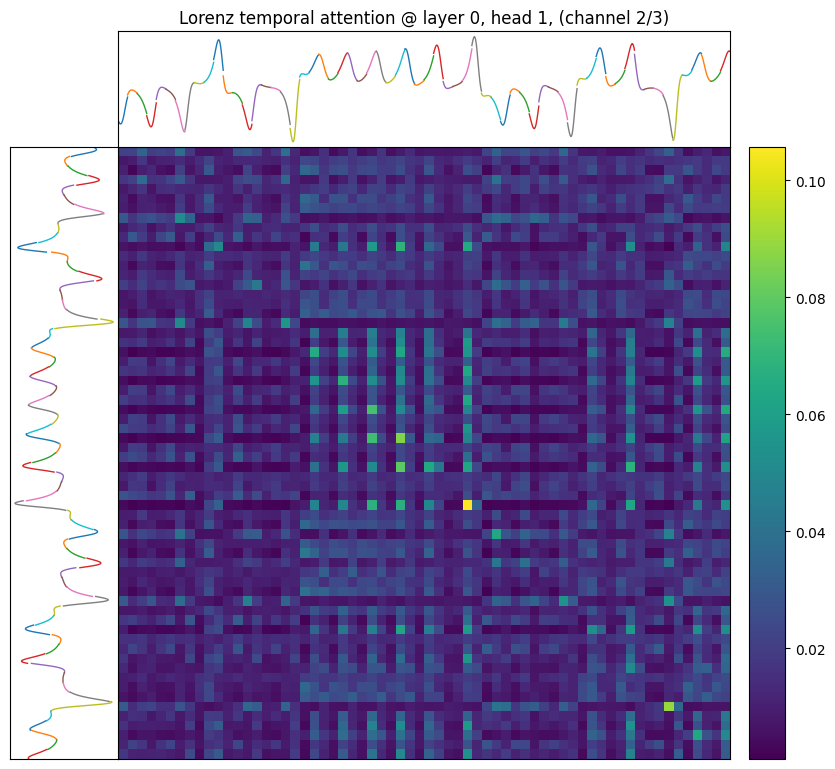

In [11]:
plot_attn_map(
    pft_model.model,
    trajectory[:, :1024],
    16,
    sample_idx=1,
    layer_idx=0,
    head_idx=1,
    prefix=syspaths[0].parent.stem + " ",
)

In [194]:
def setup_3d_axes(
    ax_3d, scale: float = 0.8, elevation: float = 30, azimuth: float = 45
):
    """Set up clean 3D axes with coordinate system from origin."""
    ax_3d.grid(False)
    ax_3d.set_axis_off()

    # Get data limits
    xmin, xmax = ax_3d.get_xlim()
    ymin, ymax = ax_3d.get_ylim()
    zmin, zmax = ax_3d.get_zlim()

    # Calculate origin and axis length
    origin = [
        min(0, xmin),
        min(0, ymin),
        min(0, zmin),
    ]  # Ensure origin includes (0,0,0)
    axis_length = scale * max(
        xmax - xmin, ymax - ymin, zmax - zmin
    )  # Slightly longer than data range

    # Plot coordinate axes with thicker lines
    ax_3d.plot(
        [origin[0], origin[0] + axis_length],
        [origin[1], origin[1]],
        [origin[2], origin[2]],
        "k-",
        lw=1.5,
    )  # x-axis
    ax_3d.plot(
        [origin[0]],
        [origin[1], origin[1] + axis_length],
        [origin[2], origin[2]],
        "k-",
        lw=1.5,
    )  # y-axis
    ax_3d.plot(
        [origin[0]], [origin[1]], [origin[2], origin[2] + axis_length], "k-", lw=1.5
    )  # z-axis

    # Add axis labels with better positioning and consistent style
    label_offset = axis_length * 1.1
    ax_3d.text(
        origin[0] + label_offset,
        origin[1],
        origin[2],
        "$x_1$",
        fontsize=12,
        ha="center",
    )
    ax_3d.text(
        origin[0],
        origin[1] + label_offset,
        origin[2],
        "$x_2$",
        fontsize=12,
        ha="center",
    )
    ax_3d.text(
        origin[0],
        origin[1],
        origin[2] + label_offset,
        "$x_3$",
        fontsize=12,
        ha="center",
    )

    # Set better viewing angle
    ax_3d.view_init(elev=elevation, azim=azimuth)  # Adjusted for better perspective

    # Ensure axes limits include both data and coordinate system
    margin = axis_length * 0.2
    ax_3d.set_xlim(origin[0], origin[0] + axis_length + margin)
    ax_3d.set_ylim(origin[1], origin[1] + axis_length + margin)
    ax_3d.set_zlim(origin[2], origin[2] + axis_length + margin)


def plot_model_prediction(
    model,
    context: np.ndarray,
    groundtruth: np.ndarray,
    prediction_length: int,
    title: str | None = None,
    save_path: str | None = None,
    elevation: float = 30,
    axis_scale: float = 0.6,
    azimuth: float = 45,
    **kwargs,
):
    context_tensor = torch.from_numpy(context.T).float().to(pft_model.device)[None, ...]
    pred = (
        model.predict(context_tensor, prediction_length, **kwargs)
        .squeeze()
        .cpu()
        .numpy()
    )
    total_length = context.shape[1] + prediction_length
    context_ts = np.arange(context.shape[1]) / total_length
    pred_ts = np.arange(context.shape[1], total_length) / total_length

    # Create figure with gridspec layout
    fig = plt.figure(figsize=(6, 8))

    # Create main grid with padding for colorbar
    outer_grid = fig.add_gridspec(2, 1, height_ratios=[0.65, 0.35], hspace=-0.2)

    # Create sub-grid for the plots
    gs = outer_grid[1].subgridspec(3, 1, height_ratios=[0.2] * 3, wspace=0, hspace=0)
    ax_3d = fig.add_subplot(outer_grid[0], projection="3d")

    ax_3d.plot(*context[:3], alpha=0.5, color="black", label="Context")
    ax_3d.plot(*groundtruth[:3], linestyle="--", color="black", label="Groundtruth")
    ax_3d.plot(*pred.T[:3], color="red", label="Prediction")
    ax_3d.set_xlabel("$x_1$")
    ax_3d.set_ylabel("$x_2$")
    ax_3d.set_zlabel("$x_3$")  # type: ignore
    setup_3d_axes(ax_3d, scale=axis_scale, elevation=elevation, azimuth=azimuth)

    if title is not None:
        title_name = title.replace("_", " ")
        ax_3d.set_title(title_name, fontweight="bold")

    axes_1d = [fig.add_subplot(gs[i, 0]) for i in range(3)]
    for i, ax in enumerate(axes_1d):
        ax.plot(context_ts, context[i], alpha=0.5, color="black")
        ax.plot(pred_ts, groundtruth[i], linestyle="--", color="black")
        ax.plot(pred_ts, pred[:, i], color="red")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect("auto")

    if save_path is not None:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, bbox_inches="tight")
    plt.show()
    plt.close()

In [195]:
dyst_name = "KawczynskiStrizhak_HyperXu"
split = "final_skew40"
subsplit = "test_zeroshot"
test_data_dirs = f"/stor/work/AMDG_Gilpin_Summer2024/data/copy/{split}"
syspaths = get_system_filepaths(dyst_name, test_data_dirs, subsplit)

sample_idx = 1
trajectory, _ = load_trajectory_from_arrow(syspaths[sample_idx])

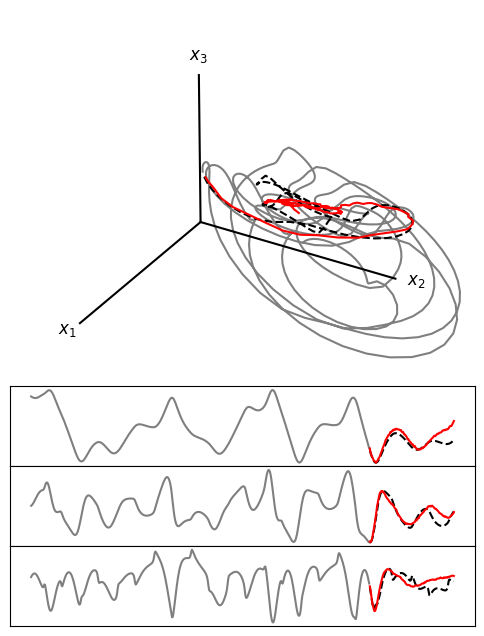

In [203]:
context_length = 512
pred_length = 128
start_time = 1260
end_time = start_time + context_length

save_path = os.path.join(
    "../figures",
    run_name,
    split,
    subsplit,
    dyst_name,
    f"{dyst_name}_sample{sample_idx}_context{start_time}-{end_time}_pred{pred_length}_.pdf",
)

plot_model_prediction(
    pft_model,
    trajectory[:, start_time:end_time],  # context
    trajectory[:, end_time : end_time + pred_length],  # ground truth
    pred_length,
    limit_prediction_length=False,
    sliding_context=True,
    save_path=save_path,  # save_path,
    azimuth=30,
    elevation=30,
    axis_scale=0.6,
)